In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [7]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
data_string = f'thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'{data_string}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000'

In [8]:
model_file = os.path.join(file_dir, f'ising_model_light_group_{param_string}.pt')
model = torch.load(model_file, weights_only=False)

In [27]:
region_table_file = os.path.join('C:\\Users','agcraig','Documents','MATLAB','plot_mmp','misc_glasser_files','HCP-MMP1_UniqueRegionList.csv')
roi_info = pandas.read_csv(region_table_file)

In [29]:
region_cortex = roi_info['cortex'].values
# There is a typo.
# print( 'Temporo-Parieto-Occipital_Junction', np.count_nonzero(region_cortex == 'Temporo-Parieto-Occipital_Junction') ) -> 9
# print( 'Temporo-Parieto_Occipital_Junction', np.count_nonzero(region_cortex == 'Temporo-Parieto_Occipital_Junction') ) -> 1
region_cortex[region_cortex == 'Temporo-Parieto_Occipital_Junction'] = 'Temporo-Parieto-Occipital_Junction'
unique_cortices = np.unique(region_cortex)
print( unique_cortices )
num_cortices = unique_cortices.size
print( num_cortices )

['Anterior_Cingulate_and_Medial_Prefrontal' 'Auditory_Association'
 'Dorsal_Stream_Visual' 'Dorsolateral_Prefrontal' 'Early_Auditory'
 'Early_Visual' 'Inferior_Frontal' 'Inferior_Parietal'
 'Insular_and_Frontal_Opercular' 'Lateral_Temporal'
 'MT+_Complex_and_Neighboring_Visual_Areas' 'Medial_Temporal'
 'Orbital_and_Polar_Frontal' 'Paracentral_Lobular_and_Mid_Cingulate'
 'Posterior_Cingulate' 'Posterior_Opercular' 'Premotor' 'Primary_Visual'
 'Somatosensory_and_Motor' 'Superior_Parietal'
 'Temporo-Parieto-Occipital_Junction' 'Ventral_Stream_Visual']
22


In [34]:
selected_threshold = 1.0
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=model.h.dtype, device=model.h.device)
threshold_index = get_closest_match(values=thresholds, target=selected_threshold)
found_threshold = thresholds[threshold_index]
mean_h = model.h[:,threshold_index,:].mean(dim=0)
h_by_cortex = [ depytorch(mean_h[region_cortex == cortex_name]) for cortex_name in unique_cortices]

In [35]:
cortex_label_no_underscore = [label.replace('_',' ') for label in unique_cortices]
print(cortex_label_no_underscore)

['Anterior Cingulate and Medial Prefrontal', 'Auditory Association', 'Dorsal Stream Visual', 'Dorsolateral Prefrontal', 'Early Auditory', 'Early Visual', 'Inferior Frontal', 'Inferior Parietal', 'Insular and Frontal Opercular', 'Lateral Temporal', 'MT+ Complex and Neighboring Visual Areas', 'Medial Temporal', 'Orbital and Polar Frontal', 'Paracentral Lobular and Mid Cingulate', 'Posterior Cingulate', 'Posterior Opercular', 'Premotor', 'Primary Visual', 'Somatosensory and Motor', 'Superior Parietal', 'Temporo-Parieto-Occipital Junction', 'Ventral Stream Visual']


Text(0, 0.5, 'h')

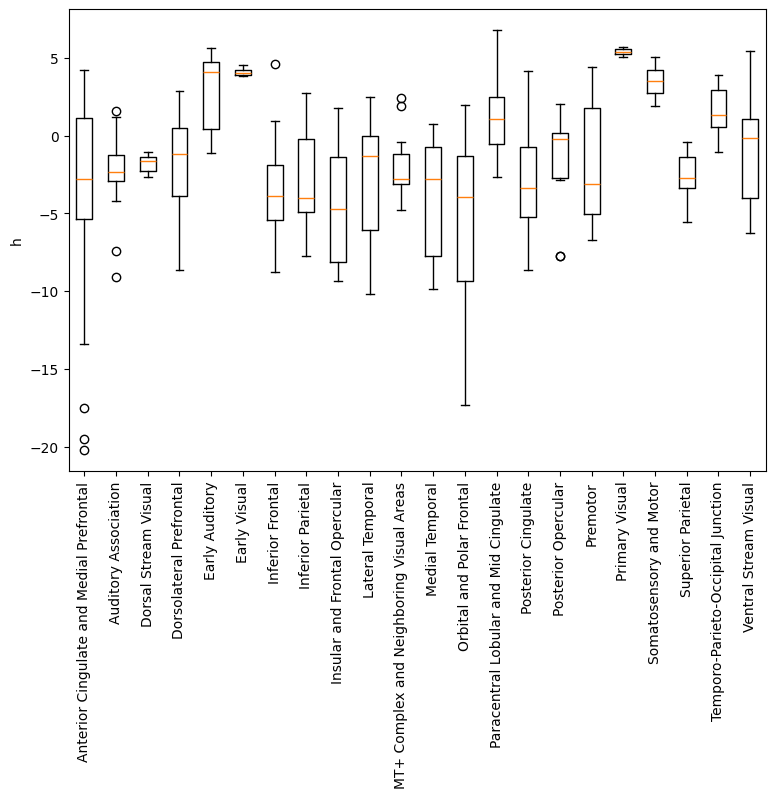

In [36]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.boxplot(h_by_cortex, tick_labels=cortex_label_no_underscore)
plt.xticks(rotation=90)
axs.set_ylabel('h')

In [33]:
unique_cortices_grouped = [ 
['Primary_Visual', 'Early_Visual', 'Dorsal_Stream_Visual', 'Ventral_Stream_Visual', 'MT+_Complex_and_Neighboring_Visual_Areas'],
['Somatosensory_and_Motor', 'Paracentral_Lobular_and_Mid_Cingulate', 'Premotor', 'Posterior_Opercular'],
['Early_Auditory', 'Auditory_Association', 'Insular_and_Frontal_Opercular'],
['Medial_Temporal', 'Lateral_Temporal'],
['Temporo-Parieto-Occipital_Junction', 'Superior_Parietal', 'Inferior_Parietal', 'Posterior_Cingulate'],
['Anterior_Cingulate_and_Medial_Prefrontal', 'Orbital_and_Polar_Frontal', 'Inferior_Frontal', 'Dorsolateral_Prefrontal']
]
group_names = ['early and intermediate visual', 'sensorimotor', 'auditory', 'other temporal', 'posterior', 'other anterior']

In [46]:
h_limits = [mean_h.min().item()-1, mean_h.max().item()+1]
print(h_limits)

[-21.209264755249023, 7.756697654724121]


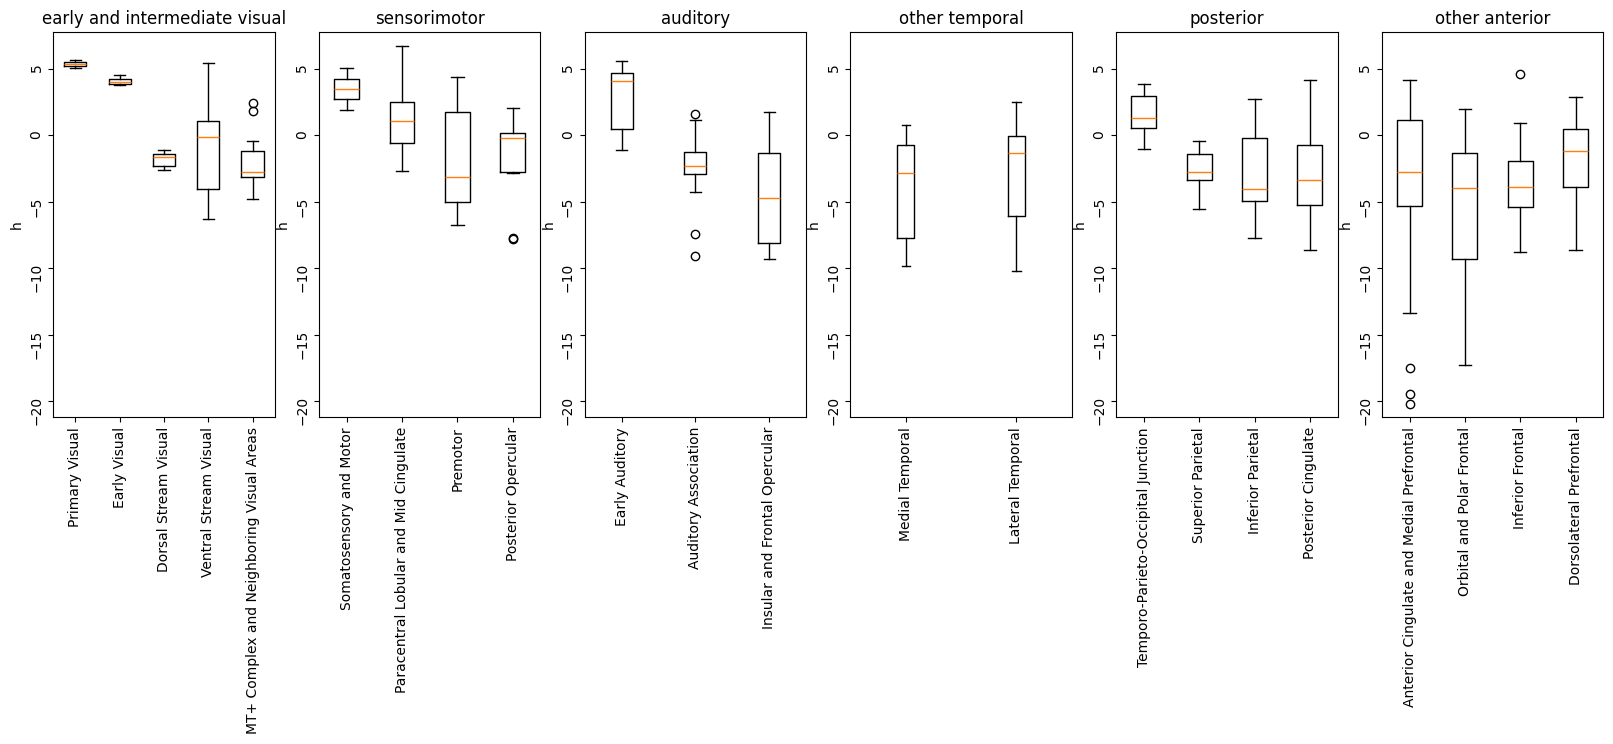

In [47]:
num_groups = len(group_names)
fig, axs = plt.subplots( nrows=1, ncols=num_groups, figsize=(20, 5) )
for group_ax, group_cortices, group_name in zip(axs, unique_cortices_grouped, group_names):
    h_by_cortex_in_group = [ depytorch(mean_h[region_cortex == cortex_name]) for cortex_name in group_cortices]
    cortex_label_in_group = [label.replace('_',' ') for label in group_cortices]
    group_ax.boxplot(h_by_cortex_in_group, tick_labels=cortex_label_in_group)
    group_ax.tick_params(labelrotation=90)
    group_ax.set_ylim(h_limits)
    group_ax.set_ylabel('h')
    group_ax.set_title(group_name)
plt.show()

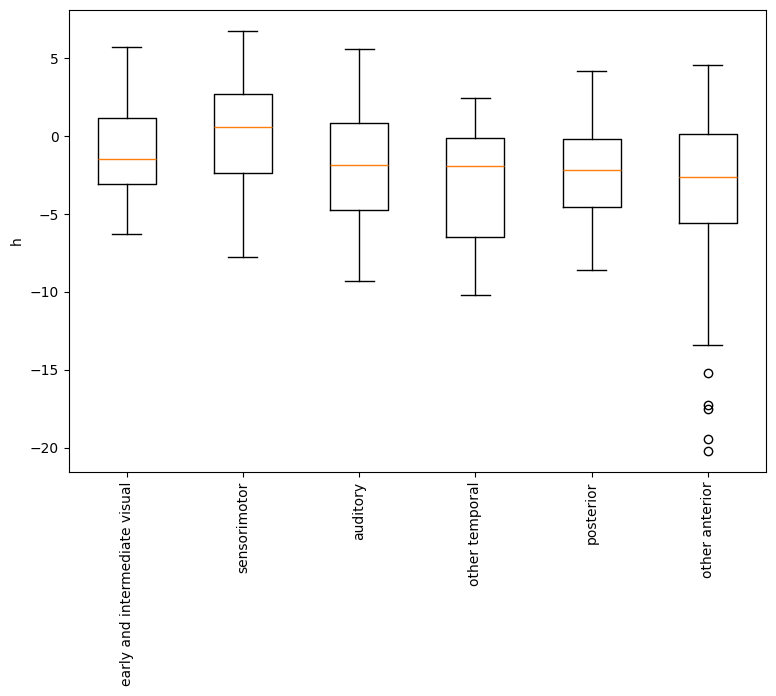

In [49]:
num_groups = len(group_names)
h_by_group = [ depytorch( mean_h[np.isin(element=region_cortex, test_elements=group_cortices)] ) for group_cortices in unique_cortices_grouped ]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.boxplot(h_by_group, tick_labels=group_names)
plt.xticks(rotation=90)
axs.set_ylabel('h')
plt.show()

In [53]:
mean_h_np = depytorch(mean_h)
side = ['greater', 'greater', 'greater', 'less', 'less', 'less']
for group_cortices, group_name, group_direction in zip(unique_cortices_grouped, group_names, side):
    is_in_group = np.isin(element=region_cortex, test_elements=group_cortices)
    is_out_of_group = np.logical_not(is_in_group)
    p_value = stats.mannwhitneyu(mean_h_np[is_in_group], mean_h_np[is_out_of_group], alternative=group_direction).pvalue
    corrected_p_value = num_groups * p_value
    print( group_name, group_direction, f'{corrected_p_value:.3g}' )

early and intermediate visual greater 0.159
sensorimotor greater 7.22e-05
auditory greater 3.74
other temporal less 0.322
posterior less 0.958
other anterior less 0.0205


In [54]:
node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False )
print( 'node features size', node_features.size() )

node features size torch.Size([837, 360, 11])


In [59]:
feature_names = ['thickness', 'myelination', 'curvature', 'sulcus depth']
selected_feature_index = 1
selected_feature_name = feature_names[selected_feature_index]
mean_node_feature = node_features[:,:,selected_feature_index].mean(dim=0)
std_mean_node_feature, mean_mean_node_feature = torch.std_mean(mean_node_feature)
node_feature_z = (mean_node_feature - mean_mean_node_feature)/std_mean_node_feature
feature_name_z = f'{selected_feature_name} (z-score)'

In [63]:
feature_limits = [node_feature_z.min().item() - 0.1, node_feature_z.max().item() + 0.1]
print(feature_limits)

[-2.063229537010193, 3.6715816020965577]


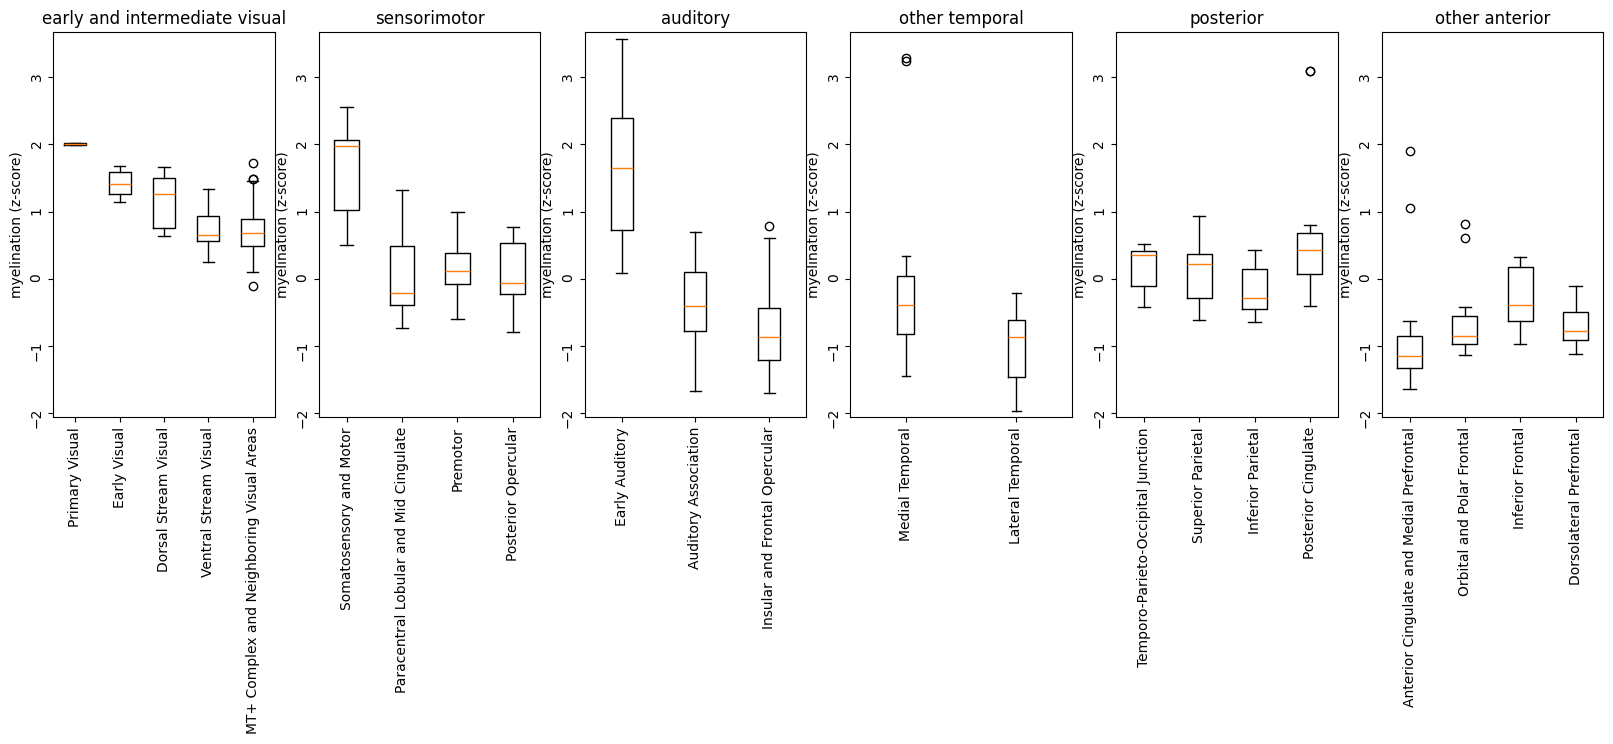

In [64]:
num_groups = len(group_names)
fig, axs = plt.subplots( nrows=1, ncols=num_groups, figsize=(20, 5) )
for group_ax, group_cortices, group_name in zip(axs, unique_cortices_grouped, group_names):
    node_feature_by_cortex_in_group = [ depytorch(node_feature_z[region_cortex == cortex_name]) for cortex_name in group_cortices]
    cortex_label_in_group = [label.replace('_',' ') for label in group_cortices]
    group_ax.boxplot(node_feature_by_cortex_in_group, tick_labels=cortex_label_in_group)
    group_ax.tick_params(labelrotation=90)
    group_ax.set_ylim(feature_limits)
    group_ax.set_ylabel(feature_name_z)
    group_ax.set_title(group_name)
plt.show()

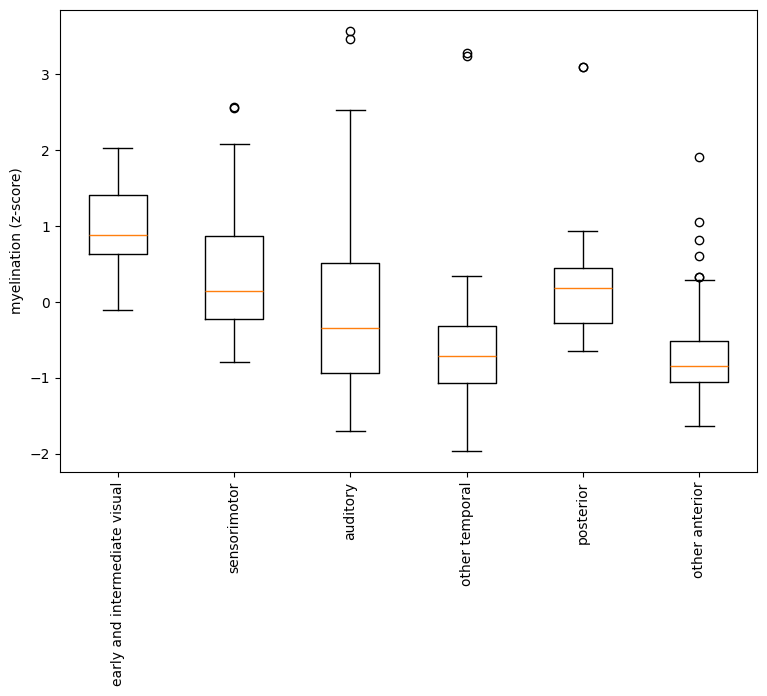

In [65]:
num_groups = len(group_names)
feature_by_group = [ depytorch( node_feature_z[np.isin(element=region_cortex, test_elements=group_cortices)] ) for group_cortices in unique_cortices_grouped ]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.boxplot(feature_by_group, tick_labels=group_names)
plt.xticks(rotation=90)
axs.set_ylabel(feature_name_z)
plt.show()

In [66]:
node_feature_z_np = depytorch(node_feature_z)
side = ['greater', 'greater', 'greater', 'less', 'less', 'less']
for group_cortices, group_name, group_direction in zip(unique_cortices_grouped, group_names, side):
    is_in_group = np.isin(element=region_cortex, test_elements=group_cortices)
    is_out_of_group = np.logical_not(is_in_group)
    p_value = stats.mannwhitneyu(node_feature_z_np[is_in_group], node_feature_z_np[is_out_of_group], alternative=group_direction).pvalue
    corrected_p_value = num_groups * p_value
    print( group_name, group_direction, f'{corrected_p_value:.3g}' )

early and intermediate visual greater 1.07e-17
sensorimotor greater 0.0014
auditory greater 5.11
other temporal less 0.000359
posterior less 5.99
other anterior less 1.62e-19


In [70]:
local_correlations_file = f'C:\\Users\\agcraig\\Documents\\MATLAB\\plot_mmp\\data\\individual_correlation_{selected_feature_name}_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.dlm'
local_correlations_table = pandas.read_csv(local_correlations_file, sep='\t')
print(local_correlations_table)
local_correlations = local_correlations_table['correlation'].values

         x      y       z  correlation  size    label
0   -11.00 -85.50  -0.422     0.000879     1     L_V1
1   -42.30 -67.80   3.750    -0.031600     1    L_MST
2   -13.60 -78.50  29.500    -0.004690     1     L_V6
3   -11.70 -80.70   1.580     0.038000     1     L_V2
4   -17.80 -85.40   4.520     0.023900     1     L_V3
..     ...    ...     ...          ...   ...      ...
355  56.90 -12.50 -15.700     0.036200     1  R_STSva
356  63.60 -27.30 -17.000    -0.026000     1   R_TE1m
357  45.10  -5.83 -12.100    -0.013600     1     R_PI
358   8.80  28.10  29.400     0.004940     1  R_a32pr
359   4.13  35.50  16.900    -0.026400     1    R_p24

[360 rows x 6 columns]


In [71]:
correlation_limits = [local_correlations.min().item() - 0.01, local_correlations.max().item() + 0.01]
print(correlation_limits)

[-0.261, 0.462]


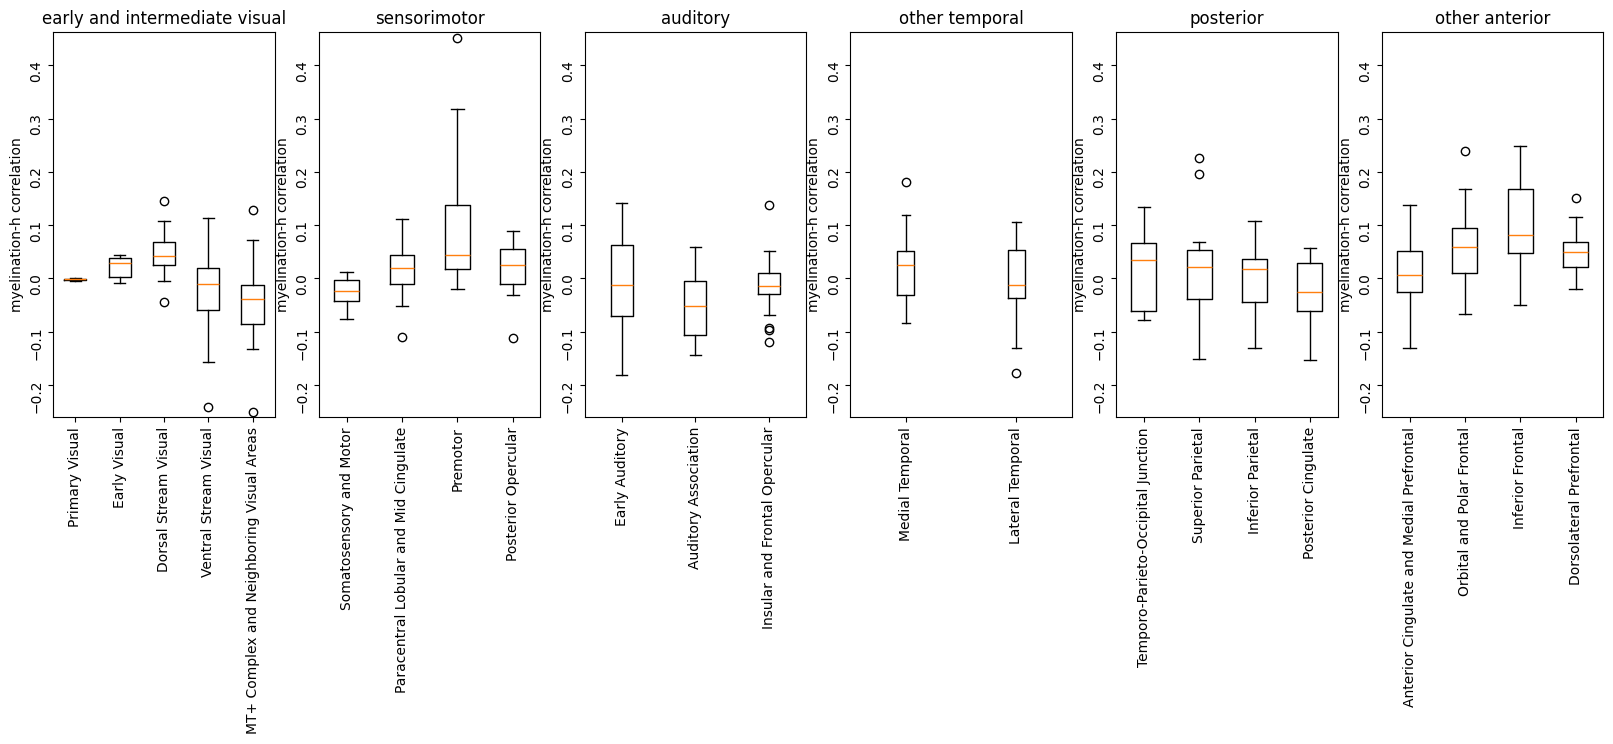

In [73]:
num_groups = len(group_names)
correlation_name = f'{selected_feature_name}-h correlation'
fig, axs = plt.subplots( nrows=1, ncols=num_groups, figsize=(20, 5) )
for group_ax, group_cortices, group_name in zip(axs, unique_cortices_grouped, group_names):
    correlation_by_cortex_in_group = [ local_correlations[region_cortex == cortex_name] for cortex_name in group_cortices]
    cortex_label_in_group = [label.replace('_',' ') for label in group_cortices]
    group_ax.boxplot(correlation_by_cortex_in_group, tick_labels=cortex_label_in_group)
    group_ax.tick_params(labelrotation=90)
    group_ax.set_ylim(correlation_limits)
    group_ax.set_ylabel(correlation_name)
    group_ax.set_title(group_name)
plt.show()

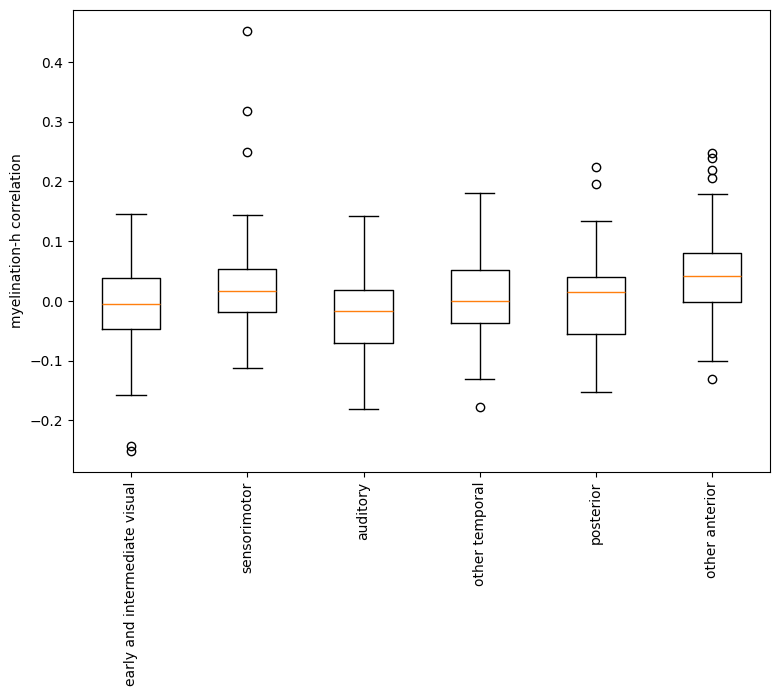

In [74]:
num_groups = len(group_names)
correlation_by_group = [ local_correlations[np.isin(element=region_cortex, test_elements=group_cortices)] for group_cortices in unique_cortices_grouped ]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.boxplot(correlation_by_group, tick_labels=group_names)
plt.xticks(rotation=90)
axs.set_ylabel(correlation_name)
plt.show()

In [75]:
side = ['two-sided', 'two-sided', 'two-sided', 'two-sided', 'two-sided', 'two-sided']
for group_cortices, group_name, group_direction in zip(unique_cortices_grouped, group_names, side):
    is_in_group = np.isin(element=region_cortex, test_elements=group_cortices)
    is_out_of_group = np.logical_not(is_in_group)
    p_value = stats.mannwhitneyu(local_correlations[is_in_group], local_correlations[is_out_of_group], alternative=group_direction).pvalue
    corrected_p_value = num_groups * p_value
    print( group_name, group_direction, f'{corrected_p_value:.3g}' )

early and intermediate visual two-sided 0.593
sensorimotor two-sided 1.35
auditory two-sided 0.00118
other temporal two-sided 3.94
posterior two-sided 0.401
other anterior two-sided 4.75e-07
